In [54]:
##Submission-NLP Time series

#Nama: Albert Budi Christian
#Email: albert.christian92@gmail.com

In [53]:
#import library yang dibutuhkan

import numpy as np 
import pandas as pd 
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

## DATASET 
Download from kaggle 
link : https://www.kaggle.com/mczielinski/bitcoin-historical-data?select=bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv

In [2]:
#baca data
train = pd.read_csv("btc.csv")

In [3]:
#cek data
train.tail(20)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4857357,1617147660,58616.33,58616.33,58616.33,58616.33,0.000691,4.051737e+01,58616.330000
4857358,1617147720,58606.95,58620.59,58606.95,58620.59,0.003404,1.995570e+02,58618.245075
4857359,1617147780,58608.96,58608.96,58606.95,58608.38,17.443451,1.022333e+06,58608.402406
4857360,1617147840,58599.78,58600.00,58599.78,58600.00,3.000086,1.758051e+05,58599.999957
4857361,1617147900,58599.99,58600.00,58599.99,58600.00,10.412178,6.101536e+05,58599.999683
4857362,1617147960,58631.74,58699.00,58631.74,58666.54,10.421432,6.116325e+05,58689.870394
4857363,1617148020,58680.18,58702.79,58680.18,58702.79,0.144199,8.461819e+03,58681.583871
4857364,1617148080,58699.45,58699.45,58675.12,58677.70,1.165074,6.836340e+04,58677.332331
4857365,1617148140,58673.20,58673.20,58644.13,58644.13,0.843998,4.949565e+04,58644.258412
4857366,1617148200,58673.20,58689.44,58673.20,58689.44,0.576412,3.382238e+04,58677.435702


In [4]:
#cek apakah ada data yang kosong
train.isnull().sum()

Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

In [5]:
#hapus data yang kosong
train = train.dropna()
train.isnull().sum()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [6]:
#convert timestamp ke format waktu untuk melakukan grouping dataset
train['date'] = pd.to_datetime(train['Timestamp'],unit='s')
group = train.groupby('date')
Harga_btc = group['Weighted_Price'].mean()

In [7]:
#Waktu prediksi harga btc
pred_range = 120
data_train= Harga_btc[:len(Harga_btc)-pred_range].values.reshape(-1,1)
data_test= Harga_btc[len(Harga_btc)-pred_range:].values.reshape(-1,1)

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(data_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(data_test)

In [8]:
#pre-process dataset untuk mencari label Y
def preprocess_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    npx = np.array(dataX)
    npy = np.array(dataY)
    rshapeX = np.reshape(npx, (npx.shape[0], 1, npx.shape[1]))
    return rshapeX, npy

train_x, train_y = preprocess_dataset(scaled_train)
test_x, test_y = preprocess_dataset(scaled_test)

In [47]:
#define model
model = Sequential()
model.add(LSTM(units = 256, activation = 'relu',return_sequences=True, input_shape = (train_x.shape[1], train_x.shape[2])))
model.add(LSTM(units = 128, input_shape = (train_x.shape[1], train_x.shape[2])))
model.add(Dense(units = 1))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 1, 256)            264192    
_________________________________________________________________
lstm_25 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 461,441
Trainable params: 461,441
Non-trainable params: 0
_________________________________________________________________


In [48]:
#compile model dan fit
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=["mae"])
callback = EarlyStopping(monitor='loss', patience=5) #callback untuk stop berdasarkan loss
history = model.fit(train_x, train_y, batch_size = 2048, epochs = 10, verbose=1, shuffle=False, validation_data=(test_x, test_y), callbacks=[callback])

Epoch 1/10
1765/1765 [==============================] - 127s 72ms/step - loss: 6.4575e-04 - mae: 0.0107 - val_loss: 0.3157 - val_mae: 0.5108
Epoch 2/10
1765/1765 [==============================] - 128s 72ms/step - loss: 0.0059 - mae: 0.0245 - val_loss: 0.2273 - val_mae: 0.4310
Epoch 3/10
1765/1765 [==============================] - 125s 71ms/step - loss: 0.0045 - mae: 0.0244 - val_loss: 0.1017 - val_mae: 0.2878
Epoch 4/10
1765/1765 [==============================] - 125s 71ms/step - loss: 0.0022 - mae: 0.0178 - val_loss: 0.0419 - val_mae: 0.1777
Epoch 5/10
1765/1765 [==============================] - 129s 73ms/step - loss: 9.1299e-04 - mae: 0.0115 - val_loss: 0.0234 - val_mae: 0.1277
Epoch 6/10
1765/1765 [==============================] - 131s 74ms/step - loss: 4.6108e-04 - mae: 0.0078 - val_loss: 0.0146 - val_mae: 0.1009
Epoch 7/10
1765/1765 [==============================] - 129s 73ms/step - loss: 2.0419e-04 - mae: 0.0050 - val_loss: 0.0080 - val_mae: 0.0726
Epoch 8/10
1765/1765 [===

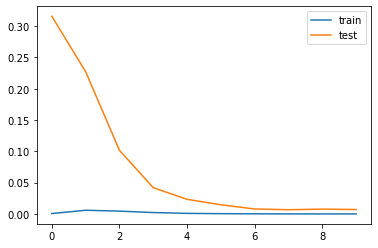

In [49]:
#plot history loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [50]:
# prediksi harga BTC
pred_harga_BTC = model.predict(test_x)
pred_harga_BTC = scaler_test.inverse_transform(pred_harga_BTC.reshape(-1, 1))

true = scaler_test.inverse_transform(test_y.reshape(-1, 1))

In [51]:
rmse = sqrt(mean_squared_error(true, pred_harga_BTC))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(true, pred_harga_BTC)
print('Test MAE: %.3f' % mae)


Test RMSE: 29.184
Test MAE: 23.910


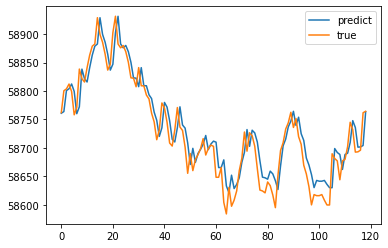

In [52]:
pyplot.plot(pred_harga_BTC, label='predict')
pyplot.plot(true, label='true')
pyplot.legend()
pyplot.show()